# Tutorial

I utilize a package called fast-arrow, which was developed by Weston Platter. It's a Robinhood API wrapper. It's great. Unfortunately, it can be a little finicky. If you have any problems, just message me and I will help figure it out. But basically, all we need acess to is options chain data. In the tutorial below, I will go through (in more depth) exactly what information we have, how it is structured. 
### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import getpass
import os
cdir =os.getcwd()
os.chdir('Fat_Tailed_Option_Model')
try:
    from Robinhood_Data_Datafetcher import Robinhood_Data
    from Fat_Tailed_Model import Fat_Tailed_Option_Model
    print('Packages Imported')
    os.chdir(cdir)
except:
    os.chdir(cdir)

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 un
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

Packages Imported


In [2]:
print('RobinHood Username:')
username = getpass.getpass()
print('RobinHood PW:')
password = getpass.getpass()
data = Robinhood_Data(username,password) 

RobinHood Username:
········
RobinHood PW:
········
Trys: 1.


### The Robinhood_Data Object
This object `data` allows us to fetch data for a given symbol. We have two methods available. One can fetch the data for a specific symbol on a specific expiration date. The method is called `data.get_options_robinhood`. The other, `data.get_all_options_robinhood` fetches *all* of the expirations. 

A quick note about a small quirk. The method `data.get_options_robinhood` returns just one pandas dataframe, containing the calls and puts together. This can be easily split into calls and puts by using a filter on the `type` column. The method `data.get_all_options_robinhood` returns three objects, which are calls, puts and the spot price. 

Further, the method `data.get_all_options_robinhood` is built on top of DASK, to hasten the datafetching process. Rather than fetch the data one after another in a loop, the data is fetched in parallel. 

In [3]:
option_df = data.get_options_robinhood('SPY',exp = '2019-09-20')
call_df,put_df = option_df.loc[option_df.type =='call'],option_df.loc[option_df.type =='put']
spot_ = call_df.spot_price.iat[0]

#### Prices

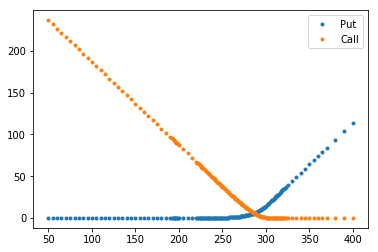

In [4]:
plt.plot(put_df.strike_price,put_df.adjusted_mark_price,'.')
plt.plot(call_df.strike_price,call_df.adjusted_mark_price,'.')
plt.legend(['Put','Call'])

#### Implied Vols

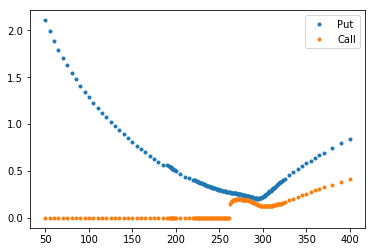

In [5]:
plt.plot(put_df.strike_price,put_df.implied_volatility,'.')
plt.plot(call_df.strike_price,call_df.implied_volatility,'.')
plt.legend(['Put','Call'])

#### Greeks

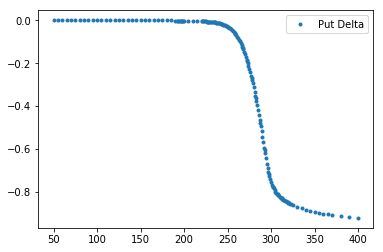

In [6]:
plt.plot(put_df.strike_price,put_df.delta,'.')
plt.legend(['Put Delta'])

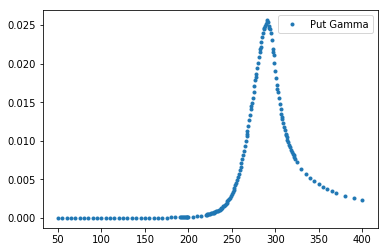

In [7]:
plt.plot(put_df.strike_price,put_df.gamma,'.')
plt.legend(['Put Gamma'])

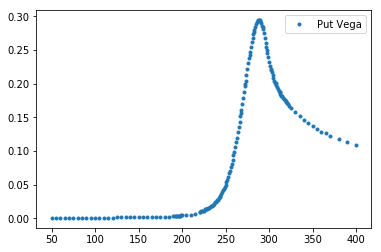

In [8]:
plt.plot(put_df.strike_price,put_df.vega,'.')
plt.legend(['Put Vega'])

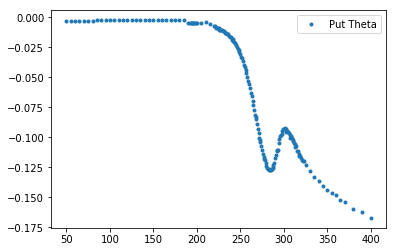

In [9]:
plt.plot(put_df.strike_price,put_df.theta,'.')
plt.legend(['Put Theta'])

# All Options

In [10]:
calls,puts,spots = data.get_all_options_robinhood('SPY')

#### We Can Look Across Expiry Now

In [11]:
g = calls.groupby('strike_price')
calendar_data = g.get_group(300)

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


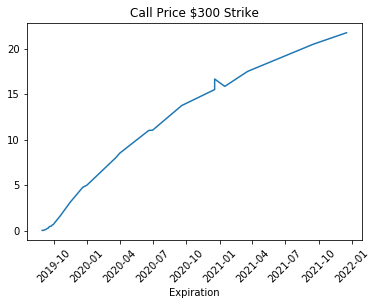

In [12]:
plt.plot(pd.to_datetime(calendar_data['expiration_date']),calendar_data.adjusted_mark_price)
plt.xlabel('Expiration')
plt.title('Call Price $300 Strike')
plt.xticks(rotation = 45);

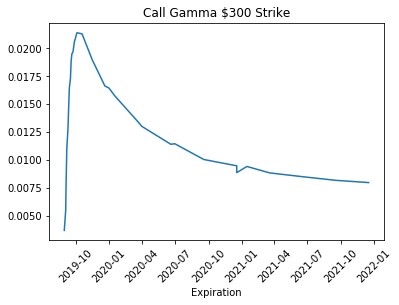

In [13]:
plt.plot(pd.to_datetime(calendar_data['expiration_date']),calendar_data.gamma)
plt.xlabel('Expiration')
plt.title('Call Gamma $300 Strike')
plt.xticks(rotation = 45);

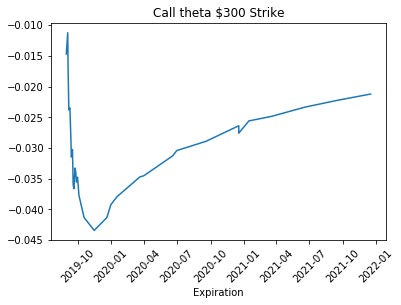

In [14]:
plt.plot(pd.to_datetime(calendar_data['expiration_date']),calendar_data.theta)
plt.xlabel('Expiration')
plt.title('Call theta $300 Strike')
plt.xticks(rotation = 45);

## Model

Using the model is quite simple

In [15]:
model = Fat_Tailed_Option_Model(symbol ='SPY',call_option_dataframe=calls,put_option_dataframe=puts,
                                cutoff_thresh=0.15,evaluation_date='2019-08-27')

In [16]:
model.fit_puts()
model.fit_calls()

/Users/tomh/Documents/GitHub/Fat Tailed Options Model/Fat-Tailed-Option-Model/Fat_Tailed_Option_Model/Fat_Tailed_Model.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.deep_otm_puts['model_price'] = np.array(fit_prices)
/Users/tomh/Documents/GitHub/Fat Tailed Options Model/Fat-Tailed-Option-Model/Fat_Tailed_Option_Model/Fat_Tailed_Model.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.deep_otm_calls['model_price'] = np.array(fit_prices)


In [17]:
print('Model Put Alpha: ',model.put_alpha)
print('Model Call Alpha: ',model.call_alpha)

Model Put Alpha:  2.362586833482927
Model Call Alpha:  3.71419078250534


In [18]:
call_groups = model.deep_otm_calls.groupby('expiration_date')
puts_groups = model.deep_otm_puts.groupby('expiration_date')

Text(0.5,1,'Tail SPY Options For 2019-12-20 Expiry')

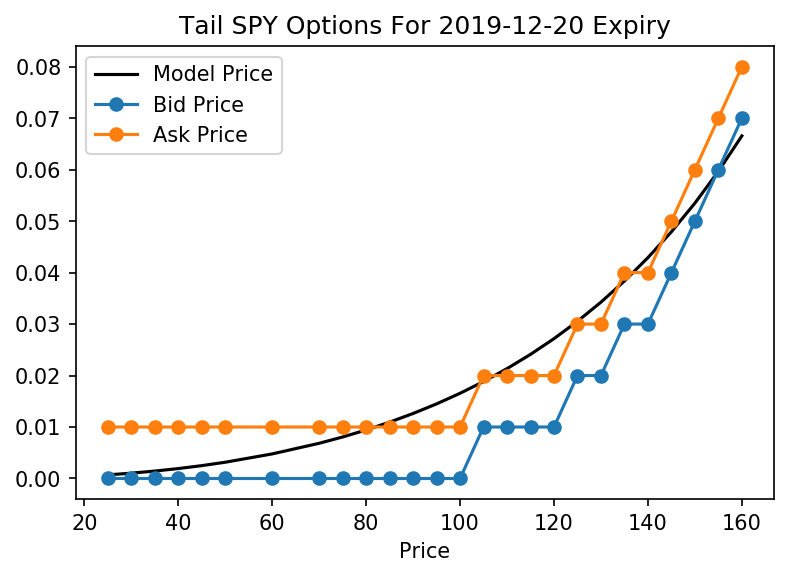

In [19]:
date = '2019-12-20'
plt.figure(figsize = (6,4),dpi = 150)
plt.plot(puts_groups.get_group(date).strike_price,puts_groups.get_group('2019-12-20').model_price,'k')
plt.plot(puts_groups.get_group(date).strike_price,puts_groups.get_group('2019-12-20').bid_price,'-o')
plt.plot(puts_groups.get_group(date).strike_price,puts_groups.get_group('2019-12-20').ask_price,'-o')
plt.xlabel("Strike")
plt.xlabel("Price")
plt.legend(['Model Price','Bid Price','Ask Price'])
plt.title('Tail SPY Options For '+date+ ' Expiry')

Text(0.5,1,'Tail SPY Options For 2019-12-20 Expiry')

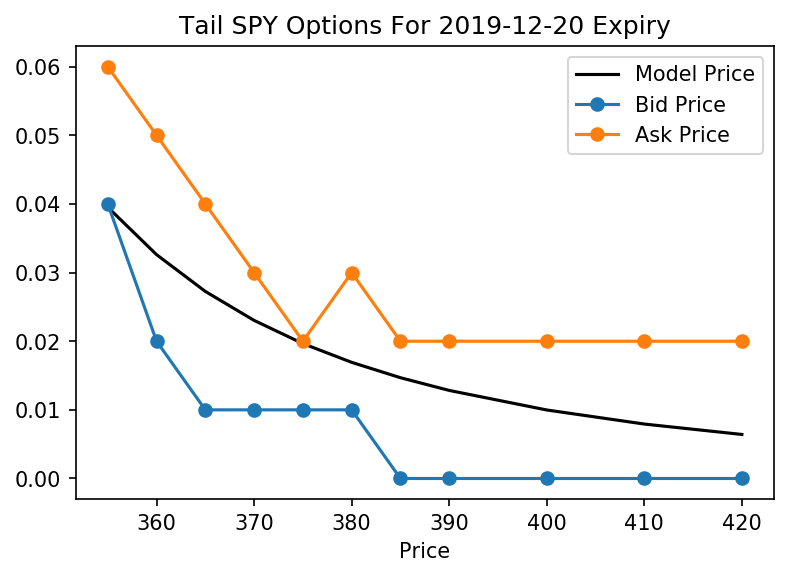

In [20]:
date = '2019-12-20'
plt.figure(figsize = (6,4),dpi = 150)
plt.plot(call_groups.get_group(date).strike_price,call_groups.get_group(date).model_price,'k')
plt.plot(call_groups.get_group(date).strike_price,call_groups.get_group(date).bid_price,'-o')
plt.plot(call_groups.get_group(date).strike_price,call_groups.get_group(date).ask_price,'-o')
plt.xlabel("Strike")
plt.xlabel("Price")
plt.legend(['Model Price','Bid Price','Ask Price'])
plt.title('Tail SPY Options For '+date+ ' Expiry')

Text(0.5,1,'Tail SPY Options For 2020-01-17 Expiry')

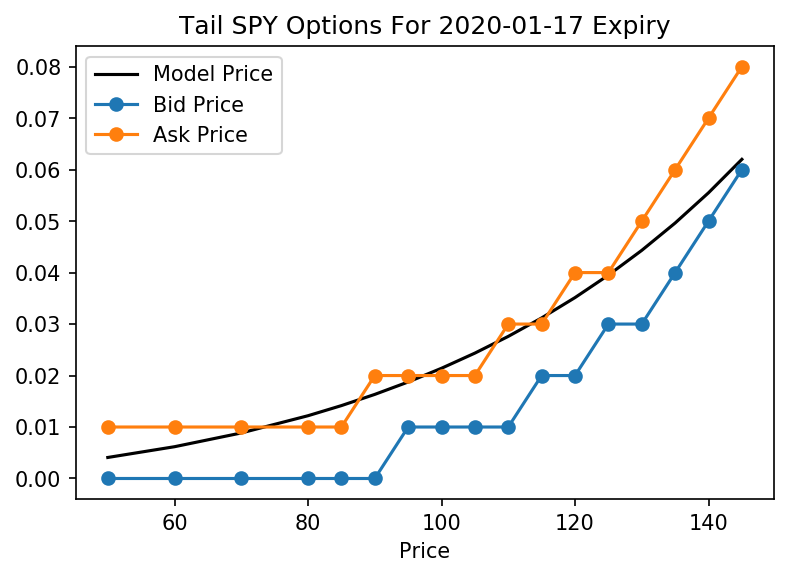

In [21]:
date = '2020-01-17'
plt.figure(figsize = (6,4),dpi = 150)
plt.plot(puts_groups.get_group(date).strike_price,puts_groups.get_group(date).model_price,'k')
plt.plot(puts_groups.get_group(date).strike_price,puts_groups.get_group(date).bid_price,'-o')
plt.plot(puts_groups.get_group(date).strike_price,puts_groups.get_group(date).ask_price,'-o')
plt.xlabel("Strike")
plt.xlabel("Price")
plt.legend(['Model Price','Bid Price','Ask Price'])
plt.title('Tail SPY Options For '+date+ ' Expiry')

Text(0.5,1,'Tail SPY Options For 2020-01-17 Expiry')

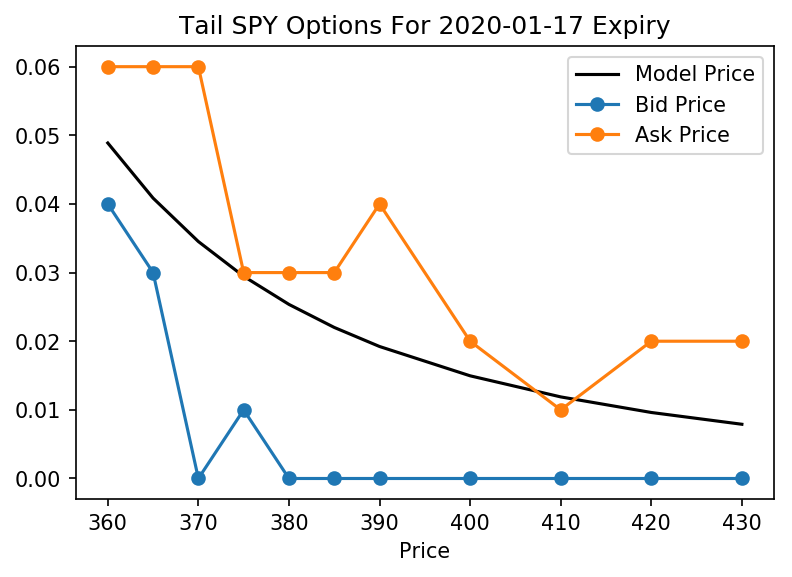

In [22]:
date = '2020-01-17'
plt.figure(figsize = (6,4),dpi = 150)
plt.plot(call_groups.get_group(date).strike_price,call_groups.get_group(date).model_price,'k')
plt.plot(call_groups.get_group(date).strike_price,call_groups.get_group(date).bid_price,'-o')
plt.plot(call_groups.get_group(date).strike_price,call_groups.get_group(date).ask_price,'-o')
plt.xlabel("Strike")
plt.xlabel("Price")
plt.legend(['Model Price','Bid Price','Ask Price'])
plt.title('Tail SPY Options For '+date+ ' Expiry')